**These Notebooks are an ongoing Project to determine 'Chameleon Trucking' Companies in The United States.This model is currently on a small sample of the data,the complete model contains over 1.3M datapoints Geocoded Via ArcGIS. For More info on Chameleon Trucking,See the following Link https://www.atlantainjurylawblog.com/uncategorized/what-is-a-chameleon-trucking-company-and-how-does-it-keep-doing-dangerous-stuff.html**

***NOTE- After plotting on Maps,the Geocoding did not properly match up for some datapoints,this was probably due to imperfect 'Address' formatting for the geocoder.arcgis('Address') function which will be corrected later,the analysis is the important part for now*** 

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from shapely.geometry import Point, LineString, mapping
from sklearn.neighbors import BallTree
from bokeh.io import output_notebook,show
from bokeh.models import GeoJSONDataSource

# User Defined Function
from nneigh.nneigh import nearest_neighbor

**Read the csvs, 2 In Service Carriers to be merged on In and Out of Service Carrier**

In [139]:
Clean_IS = pd.read_csv("C:/Users/Rae-Djamaal/Anaconda3/Lib/site-packages/Chameleon_Proj/Cl_STATE_Df1.csv")
Clean_OS_Carr = pd.read_csv("C:/Users/Rae-Djamaal/Anaconda3/Lib/site-packages/Chameleon_Proj/CL_OS_Coords.csv")

## **Create Point Objects and Convert the dataframes to Geodataframes**

In [141]:
# Create Points Objects for both
points = Clean_OS_Carr.apply(lambda row: Point(row.LON, row.LAT), axis = 1)
points1 = Clean_IS.apply(lambda row: Point(row.LON, row.LAT), axis = 1)

In [142]:
# Convert OOS Carriers to GeoDFs
Clean_OS_Carr_Gdf = gpd.GeoDataFrame(Clean_OS_Carr,geometry = points)
# Specify the coordinate ref system
Clean_OS_Carr_Gdf.crs = {'init':'epsg:4326'}
# Check the shape of the df
print(Clean_OS_Carr_Gdf.shape)

(113827, 13)


C:\Users\Rae-Djamaal\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [143]:
# Convert IS Carriers to GeoDF
Cl_STATE_Gdf = gpd.GeoDataFrame(Clean_IS,geometry = points1)
# Specify the coordinate ref system
Cl_STATE_Gdf.crs = {'init':'epsg:4326'}
print(Cl_STATE_Gdf.shape)

(199994, 10)


C:\Users\Rae-Djamaal\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


**Plot the IS and OOS Carriers - We see the spread forms a map of the USA,as expected**

(18, 60)

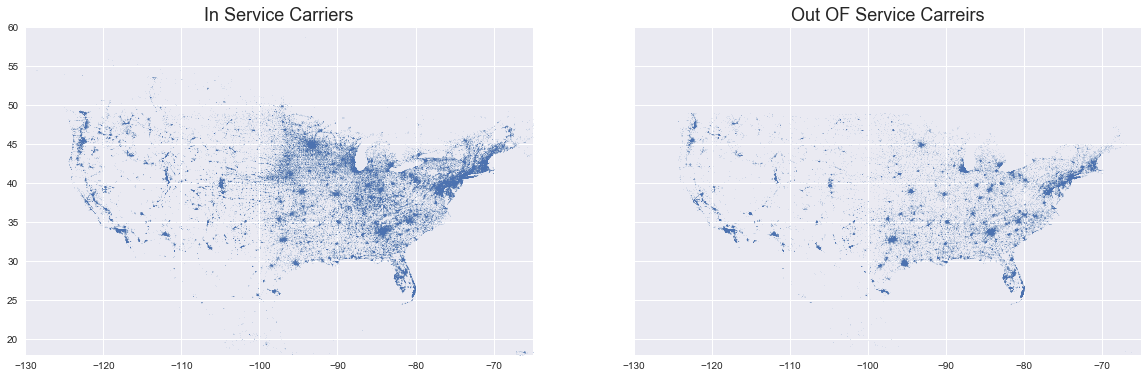

In [144]:
# set the parameter for the subplots
fig, (axis1,axis2) = plt.subplots(nrows=1, ncols=2,figsize=(20,25), sharex=True,sharey=True )

# Plot IS
IS_PLT = Cl_STATE_Gdf.plot(ax=axis1, markersize=0.01, alpha= 0.9 )
axis1.set_title('In Service Carriers',fontsize = 18)
# Zoom closer
axis1.set_xlim([-130, -65]) 
axis1.set_ylim([18, 60])


# Plot OOS
OS_PLT = Clean_OS_Carr_Gdf.plot(ax=axis2, markersize=0.01, alpha=0.9)
axis2.set_title('Out OF Service Carreirs',fontsize=18)
# Zoom closer
axis2.set_xlim([-130, -65]) 
axis2.set_ylim([18, 60])



**Examine Texas Only as a Small Test for the Algorithm**

In [145]:
TX_OS_Carr_Gdf = Clean_OS_Carr_Gdf[Clean_OS_Carr_Gdf['STATE']=='TX']

indx = list(range(0,len(TX_OS_Carr_Gdf)))
# Change indecies of Df,necessary for merging Later
TX_OS_Carr_Gdf.set_index(pd.Index(indx),inplace=True)
# Drop missing coordinates
TX_OS_Carr_Gdf= TX_OS_Carr_Gdf.dropna(subset=['LAT'])

TX_STATE_Gdf = Cl_STATE_Gdf[Cl_STATE_Gdf['STATE']=='TX']

print(TX_OS_Carr_Gdf.shape)
print(TX_STATE_Gdf.shape)

(11790, 13)
(5723, 10)


**Now Run KNN Algorithm for Texas**

In [146]:
# Run the 
closest_IS_Carr_TX = nearest_neighbor(TX_OS_Carr_Gdf, TX_STATE_Gdf, return_dist=True)

In [147]:
closest_IS_Carr_TX.tail(5)

,Address,CITY,FULL_ADDRESS,LAT,LEGAL_NAME,LON,STATE,USDOT,dba_name,geometry,distance in meters_1,distance in meters_2
11785,700 N Grant Ave,Odessa,"700 N Grant Ave,Odessa,TX",31.850649,ODESSA CHUCK WAGON GANG,-102.370941,TX,614290,NaN,POINT (-102.37094 31.85065),236.221248,352.920101
11786,6444 Colorado Road Lot 3,Smyer,"6444 Colorado Road Lot 3,Smyer,TX",33.630818,ADAN HERNANDEZ,-102.164406,TX,1079080,A TRUCKING,POINT (-102.16441 33.63082),1300.122076,6022.051645
11787,706 Broadway Ave,Gladewater,"706 Broadway Ave,Gladewater,TX",32.534847,VITAL EARTH RESOURCES INC,-94.935723,TX,458441,NaN,POINT (-94.93572 32.53485),954.750057,1295.612176
11788,11220 Main St,Houston,"11220 Main St,Houston,TX",29.663817,SHEPHERD\S UNIFORM & LINEN SUPPLY CO.,-95.438807,TX,908872,ACE IMAGEWEAR,POINT (-95.43881 29.66382),516.510442,520.456951
11789,5718 Airport Fwy,Haltom City,"5718 Airport Fwy,Haltom City,TX",32.786222,BMS CAT INC,-97.263121,TX,439457,NaN,POINT (-97.26312 32.78622),589.880949,660.580396


In [148]:
closest_IS_Carr_TX.shape

(11790, 12)

**Sanity Check to see if the length of the alorithms data frame is correct**

In [149]:
# Sanity Check if lengths add up
print(len(closest_IS_Carr_TX), '==', len(TX_OS_Carr_Gdf))

11790 == 11790


**Join The Corresponding Out of Service Carriers to their nearest In Service Carriers for Texas**

In [150]:
# Rename the Columns to distinguish between the two 
closest_IS_Carr_TX = closest_IS_Carr_TX.rename(columns={'USDOT': 'IS_USDOT','STATE'
                      :"IS_STATE", 'LEGAL_NAME': "IS_LEGAL_NAME", 'City': "IS_CITY"
                        ,'address': "IS_FULL_ADDRESS",'dba_name':'IS_DBA_NAME',
                          'LAT':"IS_LAT",'LON':'IS_LON','geometry': 
                            'IN_SERVICE_GEOMETRY'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
TX_Dist = TX_OS_Carr_Gdf.join(closest_IS_Carr_TX, lsuffix='_OS', rsuffix='_IS')

print(TX_Dist.shape)

(11790, 25)


**Quick Browse Shows we have some repeated values for Out of Service Carriers(Maybe that these have shut down and reopened multiple times),we will skip these for now,as the aim is to show prof of concept at this moment**

In [151]:
print(TX_Dist['LEGAL_NAME'].value_counts().head(10))

GEORGE STEVEN PARAISO GALVAN        3
RICARDO VEGA                        3
ADRIAN GARCIA                       3
LUIS SANCHEZ                        3
ABRAM REIMER                        3
BLACKLINE OIL FIELD SERVICES LLC    2
SAUL RODRIGUEZ                      2
EMIGDIO FUENTES                     2
CARLOS ZAVALA                       2
JAMES JONES                         2
Name: LEGAL_NAME, dtype: int64


**Lets Plot Them to get a Better Idea - Almost all OOS Carriers Appear once,as expected**

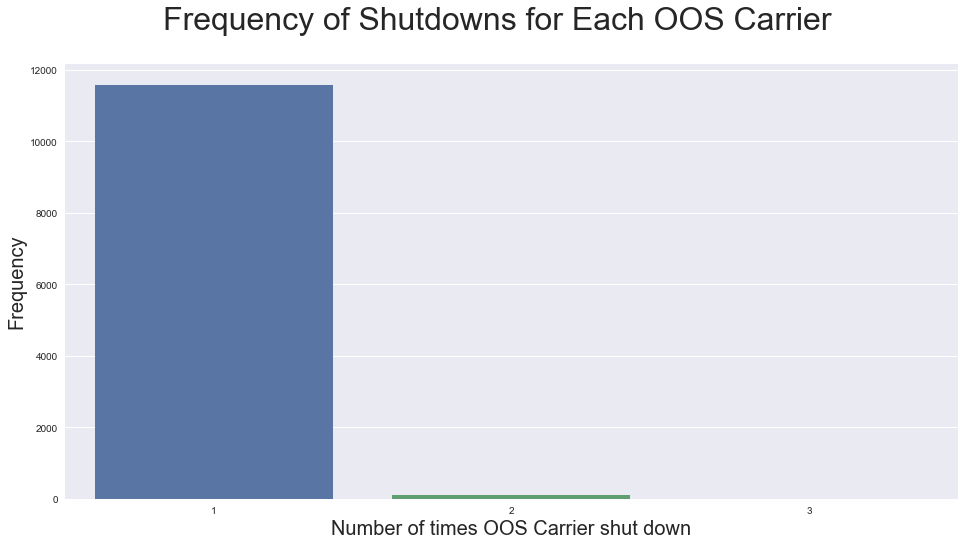

In [152]:
carrier_count = TX_Dist['LEGAL_NAME'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(16,8))
sns.countplot(x = carrier_count.index, data = carrier_count)

plt.ylabel('Frequency', fontsize= 20)
plt.xlabel('Number of times OOS Carrier shut down', fontsize=20)
plt.suptitle('Frequency of Shutdowns for Each OOS Carrier',fontsize= 32)
plt.show()

**Now that we have the distances,lets convert these numerical to categorical variables - I will arbitrarily use 150 Meters as the Cuttoff**

In [153]:
# Use 150 Meters as Cutoff
TX_Dist["Category_1"] = TX_Dist['distance in meters_1'] < 150
TX_Dist["Category_2"] = TX_Dist['distance in meters_2'] < 150

# Make Binary Variable
TX_Dist["Category_1"] = TX_Dist["Category_1"].astype(int)
TX_Dist["Category_2"] = TX_Dist["Category_2"].astype(int)

# Convert Binary to categorical 1 Chameleon 0 Legitimate
TX_Dist["Category_1"] = pd.Categorical(TX_Dist["Category_1"])
TX_Dist["Category_2"] = pd.Categorical(TX_Dist["Category_2"])
TX_Dist.dtypes

USDOT                      int64
LEGAL_NAME                object
DBA_NAME                  object
ZIP_CODE                  object
STATE                     object
CITY_OS                   object
STREET                    object
OOS_REASON                object
OOS_DATE                  object
OOS_STATUS                object
LAT                      float64
LON                      float64
geometry                geometry
Address                   object
CITY_IS                   object
FULL_ADDRESS              object
IS_LAT                   float64
IS_LEGAL_NAME             object
IS_LON                   float64
IS_STATE                  object
IS_USDOT                 float64
IS_DBA_NAME               object
IN_SERVICE_GEOMETRY     geometry
distance in meters_1     float64
distance in meters_2     float64
Category_1              category
Category_2              category
dtype: object

**Check Unique Connections**

In [154]:
# Unique
len(TX_Dist['IS_LEGAL_NAME'].unique()) 
# Duplicates
len(TX_Dist[TX_Dist['IS_LEGAL_NAME'].duplicated()])

# % of Unique Connections
print("%{00:.2f}".format(len(TX_Dist['IS_LEGAL_NAME'].unique())/len(TX_Dist)*100), "of OOS Carriers matched to 1 unique IS carrier")

%28.86 of OOS Carriers matched to 1 unique IS carrier


**All Set Now**

In [155]:
print("There are probably",TX_Dist['Category_1'].value_counts().loc[0],"Legitimate Carriers in Texas")
print("There are possibly", TX_Dist['Category_1'].value_counts().iloc[1],"Chameleon Carriers in Texas")

There are probably 10745 Legitimate Carriers in Texas
There are possibly 1045 Chameleon Carriers in Texas


**Validate 150m choice-We see the Avergage distance to the closest IS Service Carrier is 960 Meters,so based on our data,a cutoff of 150 meters more than a fair assumption**

In [156]:
TX_Dist['distance in meters_1'].describe()

count    11033.000000
mean       958.534778
std       1651.855227
min          0.667906
25%        300.047515
50%        552.621022
75%       1027.978694
max      73607.531443
Name: distance in meters_1, dtype: float64

# **Now Run KNN On all states**

**Removing those with missing LAT, LON coordinates**

In [157]:
# Drop Missing LAT and LONGS
#Clean_OS_Carr_Gdf.isna().any()
Clean_OS_Gdf= Clean_OS_Carr_Gdf.dropna(subset=['LAT'])
Clean_OS_Gdf.reset_index(drop=True, inplace=True)
len(Clean_OS_Gdf)

105669

In [158]:
closest_IS_All = nearest_neighbor(Clean_OS_Gdf, Cl_STATE_Gdf, return_dist=True)

In [159]:
# Rename the Columns to distinguish between the two 
closest_IS_All = closest_IS_All.rename(columns={'USDOT': 'IS_USDOT','STATE':"IS_STATE", 'LEGAL_NAME': "IS_LEGAL_NAME", 'City': "IS_CITY",'address': "IS_FULL_ADDRESS",'dba_name':'IS_DBA_NAME','LAT':"IS_LAT",'LON':'IS_LON','geometry': 'IN_SERVICE_GEOMETRY'})
#closest_stops.drop([ "LAT","LON"] , axis=1, inplace=True)

# Merge the datasets by index (for this, it is good to use '.join()' -function)
Merge_Closest = Clean_OS_Gdf.join(closest_IS_All,lsuffix='_OS', rsuffix='_IS')
#Merge_Closest.columns

**Check Percentage of Unique Connections**

In [160]:
# Unique
len(Merge_Closest['IS_LEGAL_NAME'].unique()) 
# Duplicates
len(Merge_Closest[Merge_Closest['IS_LEGAL_NAME'].duplicated()])

# % of Unique Connections
print("%{00:.2f}".format(len(Merge_Closest['IS_LEGAL_NAME'].unique())/len(Merge_Closest)*100), 'of OOS carriers matched to One unique IS Carrier')

%53.36 of OOS carriers matched to One unique IS Carrier


# **`Vizualise Some of the  Connections`**

**Function to get the x,y coords from the Linestring object**

In [161]:
# Get Link Proj Coords
def getLineCoords(row, geom, coord_type):
    """Returns a list of coordinates ('x' or 'y') of a LineString geometry"""
    if coord_type == 'x':
        return list( row[geom].coords.xy[0] )
    elif coord_type == 'y':
        return list( row[geom].coords.xy[1] )

### **Statitc Plot of Linkages**

In [162]:
# Create a link (LineString) between IS and OOS
Merge_Closest['link'] = Merge_Closest.apply(lambda row: LineString([row['geometry'], row['IN_SERVICE_GEOMETRY']]), axis=1)

# Set link as the active geometry
Merge_Closest_links = Merge_Closest.copy()
Merge_Closest_links = Merge_Closest_links.set_geometry('link')

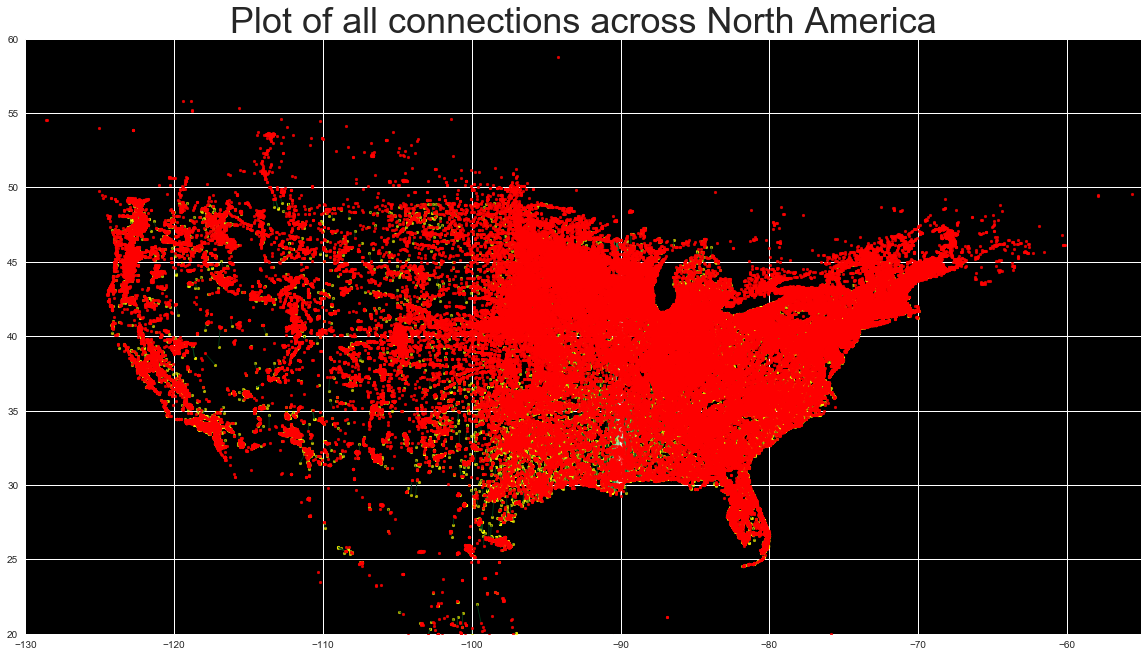

In [164]:
# Plot the connecting links between IS and OOS Carriers them based on distance
ax = Merge_Closest_links.plot(column='distance in meters_1', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.9, figsize=(20, 20))
ax = Clean_OS_Gdf.plot(ax=ax, color='yellow', markersize=8, alpha=0.7)
ax = Cl_STATE_Gdf.plot(ax=ax, markersize=8, marker='o', color='red', alpha=0.9, zorder=2)

# Title
plt.title('Plot of all connections across North America',fontsize=36)
fig.tight_layout()

ax.set_xlim([-130, -55]) 
ax.set_ylim([20, 60])
# Set map background color to black
ax.set_facecolor('black')

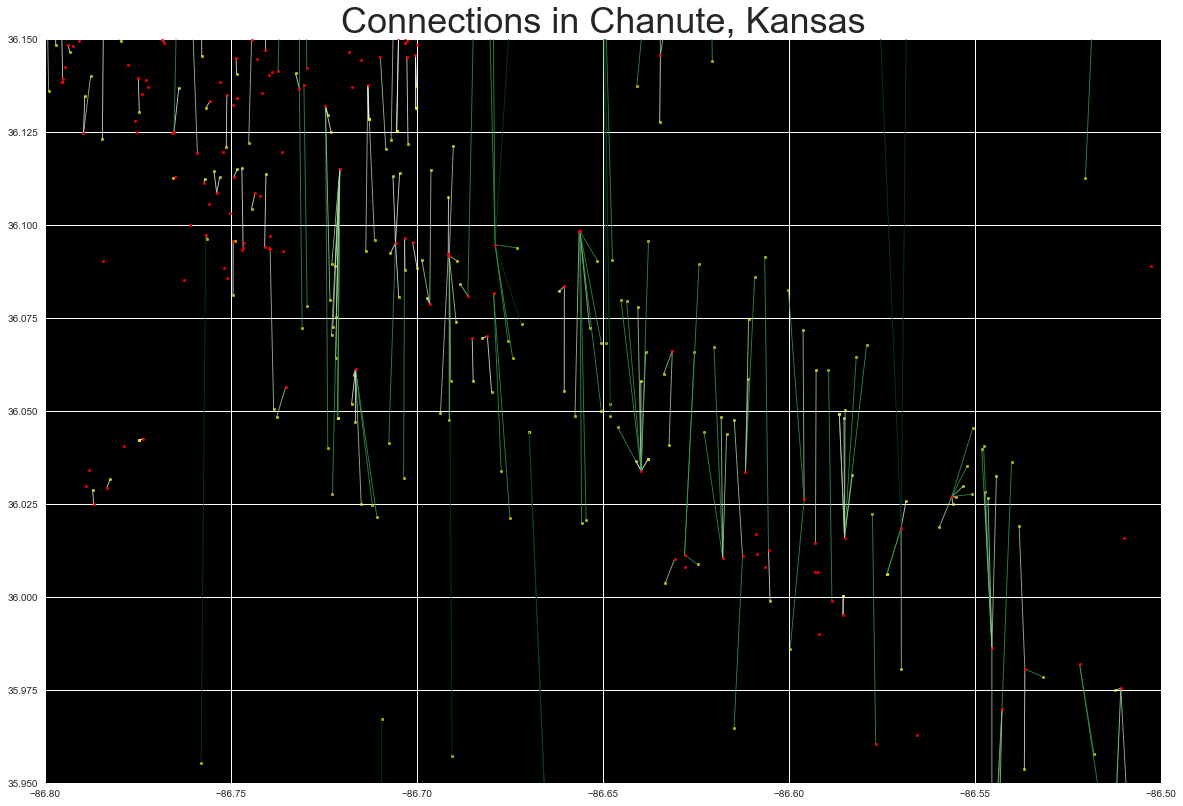

In [167]:
# Zommed in Image of Connections

# Plot the connecting links between IS and OOS Carriers them based on distance
ax = Merge_Closest_links.plot(column='distance in meters_1', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.9, figsize=(20, 20))
ax = Clean_OS_Gdf.plot(ax=ax, color='yellow', markersize=8, alpha=0.7)
ax = Cl_STATE_Gdf.plot(ax=ax, markersize=8, marker='o', color='red', alpha=0.9, zorder=2)

plt.title('Connections in Chanute, Kansas',fontsize=36)
fig.tight_layout()
ax.set_xlim([-86.8, -86.5]) 
ax.set_ylim([35.95, 36.15])
ax.set_facecolor('black')

**Lets Make 150 meters a threshold as suspicious company**

In [168]:
# Use 150 Meters as Cutoff
Merge_Closest["Category_1"] = Merge_Closest['distance in meters_1'] <= 150
Merge_Closest["Category_2"] = Merge_Closest['distance in meters_2'] <= 150

# Make Binary Variable
Merge_Closest["Category_1"] = Merge_Closest["Category_1"].astype(int)
Merge_Closest["Category_2"] = Merge_Closest["Category_2"].astype(int)

# Convert Binary to categorical 1 Chameleon 0 Legitimate
Merge_Closest["Category_1"] = pd.Categorical(Merge_Closest["Category_1"])
Merge_Closest["Category_2"] = pd.Categorical(Merge_Closest["Category_2"])

**Check the Numbers on these suspicious companies**

No of IS Carriers within 150 meters of an OOS carrier =  21038
Percent of carriers within 150 meters of an OOS carrier =  %19.91


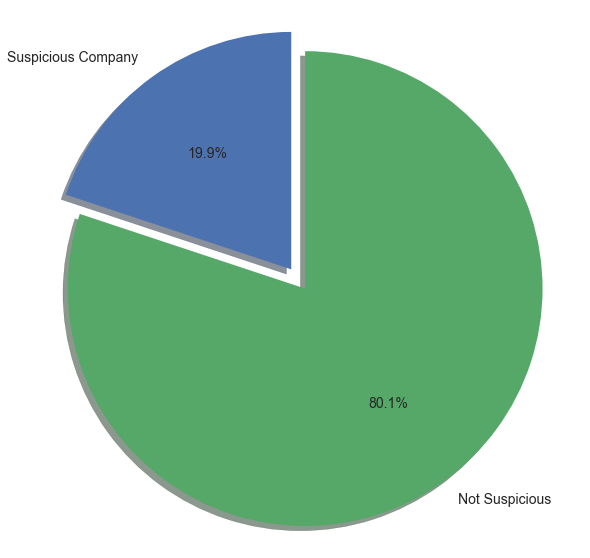

In [182]:
# Count length of threshold
Len_Thresh = Merge_Closest["Category_1"].value_counts()[1]

# Count all
Len_DF = sum(Merge_Closest["Category_1"].value_counts())

print("No of IS Carriers within 150 meters of an OOS carrier = ",Less_Thresh)
print("Percent of carriers within 150 meters of an OOS carrier = ","%{00:.2f}".format(Len_Thresh*100/Len_DF))

# Pie Chart
labels = ['Suspicious Company', 'Not Suspicious']
sizes = [Len_Thresh,Len_DF-Len_Thresh]
explode = (0.1, 0) 

fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90,textprops={'fontsize': 14})
ax1.axis('equal') 
plt.show()

# **Interactive Plot**

**Convert Linkages to projected linestring**

In [ ]:
Links_IS_OS = Merge_Closest_links

data_proj = Links_IS_OS.copy()

# Reproject the geometries by replacing the values with projected ones
data_proj = data_proj.to_crs(epsg=3035)

In [ ]:
# apply our function 

# Calculate x coordinates of the line
data_proj['x'] = data_proj.apply(getLineCoords, geom='link', coord_type='x', axis=1)

# Calculate y coordinates of the line
data_proj['y'] = data_proj.apply(getLineCoords, geom='link', coord_type='y', axis=1)

In [ ]:
# Drop all variables except x,y,link
Links_NO =  data_proj.filter(['x','y','link'])

**Jsonify the GeoDF of x, y and link**

In [ ]:
Links_IS_OS = GeoJSONDataSource(geojson= Links_NO.to_json())

**Interactive Plot of Linkages**

In [ ]:
pjs = figure(title="IS and OS Connections")

# Add the lines to the map from our 'msource' ColumnDataSource -object
pjs.multi_line('x','y', source= Links_IS_OS , color='green', line_width=3)

# outjs = r"C:\Users\Rae-Djamaal\Anaconda3\Lib\site-packages\Chameleon_Proj\Connects_map.html"

# # Save the map
# save(pjs, outjs)


# Output Interactive Plot in Notebook
output_notebook()
show(pjs, notebook_handle = True)